In [1]:
import pandas as pd
import numpy as np
import pandas.io.sql as pd_sql
import sqlite3 as sql
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
%matplotlib notebook

In [2]:
con = sql.connect(r'c:\users\rebecca\.spyder-py3\movies.db') 

movies = pd_sql.read_sql('select * from finalMovies_20180804', con, index_col='index')


## ---------------------------------------
## Regression Models
## ---------------------------------------

In [11]:
####Experiment: revenue greater than $100,000
test = movies[(movies['Revenue_Real']>100000)&(movies['Budget_Real']>0)
              &(movies['Rating_RT']>=0) & (movies['imdbVotes']>0)&
             (movies['Length']>0)]

#Put zero where null
test['Revenue_Actor_Real']=test['Revenue_Actor_Real'].apply(lambda x: 0 if pd.isnull(x) else x)
test['Revenue_Director_Real']=test['Revenue_Director_Real'].apply(lambda x: 0 if pd.isnull(x) else x)
test['Revenue_Writer_Real']=test['Revenue_Writer_Real'].apply(lambda x: 0 if pd.isnull(x) else x)
test['Revenue_Real_Log']=np.log(test['Revenue_Real'])
test['Budget_Real_Log']=np.log(test['Budget_Real'])
test['Revenue_Actor_Real_Log']=np.log(test['Revenue_Actor_Real'])
test['Revenue_Director_Real_Log']=np.log(test['Revenue_Director_Real'])
test['Revenue_Writer_Real_Log']=np.log(test['Revenue_Writer_Real'])

C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/i

In [9]:
import statsmodels.api as sm


###ADD CONSTANT


model = sm.OLS((test['Revenue_Real']), test[['Budget_Real', 
'Rating_RT', 
'Summer', 'Winter', 'Holiday',
'Genre_Drama','Genre_Comedy', 
'Rated_G_PG', 'Rated_R', 'Rated_PG-13',
'Comp_DreamWorks','Comp_Fox','Comp_Lionsgate','Comp_MGM',
'Comp_Miramax','Comp_Paramount','Comp_Sony',
'Comp_Universal','Comp_WarnerBros', 'Comp_Other', 
'Revenue_Actor_Real','Revenue_Director_Real','Revenue_Writer_Real',
'isCollection', 'Length']])

In [10]:
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           Revenue_Real   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     386.6
Date:                Sun, 12 Aug 2018   Prob (F-statistic):               0.00
Time:                        18:17:02   Log-Likelihood:                -75879.
No. Observations:                3769   AIC:                         1.518e+05
Df Residuals:                    3744   BIC:                         1.520e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Budget_Real               2.44

<IPython.core.display.Javascript object>


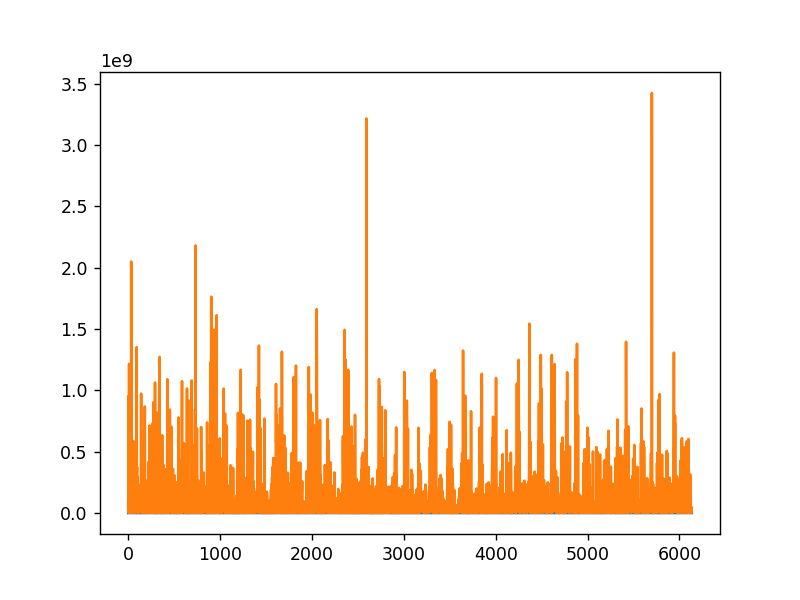

In [6]:
%matplotlib notebook
plt.plot(results.fittedvalues)#, test['Revenue_Real'])
plt.plot(test['Revenue_Real'])

In [18]:
test2 = test[(test['Date']>='2011-01-01')]
model = sm.OLS((test2['Revenue_Real_Log']), test2[['Length']])

In [19]:
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       Revenue_Real_Log   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                 5.263e+04
Date:                Sun, 12 Aug 2018   Prob (F-statistic):               0.00
Time:                        18:33:10   Log-Likelihood:                -3597.2
No. Observations:                1461   AIC:                             7196.
Df Residuals:                    1460   BIC:                             7202.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Length         0.1575      0.001    229.414      0.0

## ---------------------------------------
## Classification Models
## ---------------------------------------

******************
RandomForest
******************

In [7]:
####Experiment: revenue greater than $100,000
test2 = movies[(movies['Revenue_Real']>0)&(movies['Budget_Real']>0) &
              (movies['Length']>0) & (movies['Rating_RT']>0)&
              (movies['Rating_IMDB']>0)&(movies['Rating_Metacritic']>0)]
#test2 = movies[(movies['Revenue_Real']>100000) & (movies['Budget_Real']>0)]

#Make binary variable for if movie made at least 2x budget
test2['Profit_Bucket_Binary']=np.where(test2['Profit_Bucket']=='<1x', 0, np.where(test2['Profit_Bucket']=='[1-2x)', \
    0, np.where(test2['Profit_Bucket']=='[2-3x)', 1, np.where(test2['Profit_Bucket']=='[3-4x)', \
                       1, np.where(test2['Profit_Bucket']=='[4-5x)', 1, np.where(test2['Profit_Bucket']=='>=5x', 1, ''))))))

#Put zero where null
test2['Revenue_Actor_Real']=movies['Revenue_Actor_Real'].apply(lambda x: 0 if pd.isnull(x) else x)
test2['Revenue_Director_Real']=movies['Revenue_Director_Real'].apply(lambda x: 0 if pd.isnull(x) else x)
test2['Revenue_Writer_Real']=movies['Revenue_Writer_Real'].apply(lambda x: 0 if pd.isnull(x) else x)


C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Rebecca\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

0    1997
1    1680
Name: Profit_Bucket_Binary, dtype: int64


C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<IPython.core.display.Javascript object>


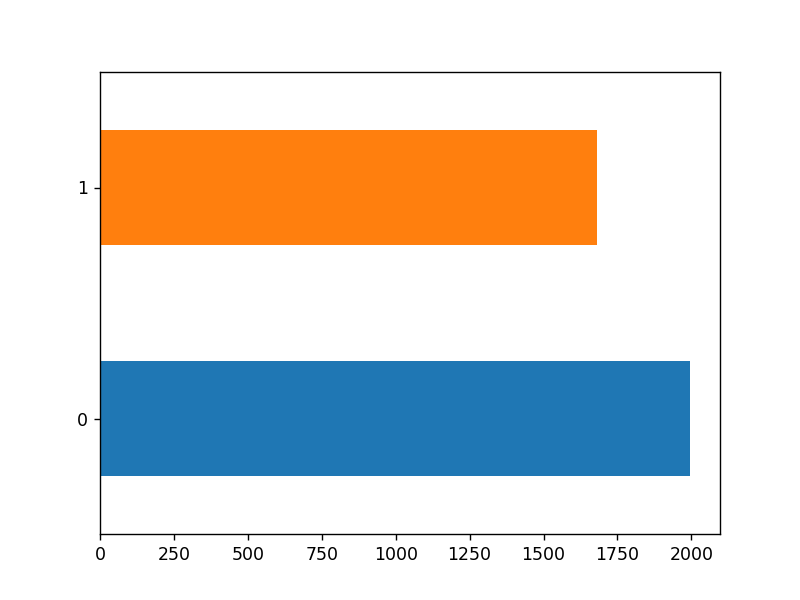

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split

#Show distribution of profit bucket binary
print(test2['Profit_Bucket_Binary'].value_counts())
test2['Profit_Bucket_Binary'].value_counts().plot(kind='barh')

In [74]:
###Try doing just profit bucket <2, >2
###DISCUSS WHETHER IMDB VOTES OR AWARDS ARE APPROPRIATE VARIABLES!!!!!!
###They are good predictors, but we won't have those numbers before a movie opens, but potentially during a movie's run.
X = test2[["Budget_Real", "Holiday", "Summer", "Spring", "Fall", "Winter",
'Rating_RT', 'Rating_IMDB', 'Rating_Metacritic',           
'isCollection',
'Length',
'Genre_Drama',
 'Genre_Comedy',
 'Genre_Action_Adventure',
 'Genre_Thriller_Horror',
 'Genre_Romance',
 'Genre_Crime_Mystery',
 'Genre_Animation',
 'Genre_Scifi',
 'Genre_Documentary',
 'Genre_Other',
 'Rated_G_PG',
 'Rated_PG-13',
 'Rated_R',
 'Rated_Other',
'Comp_Disney',
 'Comp_DreamWorks',
 'Comp_Fox',
 'Comp_Lionsgate',
 'Comp_MGM',
 'Comp_Miramax',
 'Comp_Paramount',
 'Comp_Sony',
 'Comp_Universal',
 'Comp_WarnerBros',
 'Comp_Other',  
'Revenue_Actor_Real',
'Revenue_Director_Real', 
'Revenue_Writer_Real',
'Nominated_Major', 
'Nominated_Minor', 
'Won_Major', 
'Won_Minor'
]]
#y = test2["Profit_Bucket"]
y = test2["Profit_Bucket_Binary"]

In [10]:
rf = RandomForestClassifier(n_estimators=50, oob_score=True) 

# Next split up the data with the 'train test split' method in the Cross Validation module
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

# ...and then run the 'fit' method to build a forest of trees
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [11]:
rf.score(X_test, y_test)

0.7608695652173914

In [12]:
#Got code to determine most important feature from here:
#https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
feature_importances = pd.DataFrame(rf.feature_importances_,
   index = X_train.columns,columns=['importance']).sort_values('importance',
    ascending=False)
(feature_importances.head(10))

,importance
Nominated_Minor,0.081030
Budget_Real,0.078359
Rating_IMDB,0.069601
Rating_RT,0.066728
Revenue_Actor_Real,0.065530
Length,0.063922
Rating_Metacritic,0.063438
Revenue_Writer_Real,0.063238
Won_Minor,0.059752
isCollection,0.056598


******************
SVM
******************

In [13]:
from sklearn.svm import SVC
#kernels = ['linear', 'poly', 'rbf']

splits     = cross_validation.train_test_split(X,y, test_size=0.2)
X_train, X_test, y_train, y_test = splits

#for kernel in kernels:
#    if kernel != 'poly':
#        model      = SVC(kernel=kernel)
#    else:
#        model      = SVC(kernel=kernel, degree=3)

model = SVC()
        
model.fit(X_train, y_train)
model.score(X_test, y_test)
#expected   = y_test
#predicted  = model.predict(X_test)

#SVC_report = classification_report(expected, predicted)

0.5407608695652174

In [16]:
print(model.get_params())

{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


******************
Logistic Regression
******************

In [17]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=1)

In [18]:

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size = 0.2)
log_reg = lr.fit(X_train, y_train)
log_reg.score(X_test, y_test)

0.595108695652174

In [36]:
#print(log_reg.coef_.transpose())
#feature_importances = pd.DataFrame(log_reg.coef_).transpose()
#feature_importances.head(5)
feature_importances = pd.DataFrame(log_reg.coef_.transpose(),
   index = X_train.columns,columns=['importance']).sort_values('importance',
    ascending=False)
feature_importances.abs().sort_values(by='importance', ascending=False)
(feature_importances.head(10))

,importance
Revenue_Writer_Real,2.370079e-10
Revenue_Director_Real,9.256614e-11
Budget_Real,9.162592e-11
Nominated_Minor,5.940808e-15
Won_Minor,3.169147e-15
Rating_RT,2.665879e-16
isCollection,9.220472e-17
Nominated_Major,8.947427e-17
Won_Major,6.464770e-17
Comp_Fox,2.992838e-17


******************
XGBoost
******************

In [37]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
seed=3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=seed)
model=XGBClassifier()
model.fit(X_train, y_train)
model.score(X_test, y_test)

C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7228260869565217

In [38]:
feature_importances = pd.DataFrame(model.feature_importances_,
   index = X_train.columns,columns=['importance']).sort_values('importance',
    ascending=False)
(feature_importances.head(10))

,importance
Budget_Real,0.134307
Rating_IMDB,0.091971
Nominated_Minor,0.083212
Revenue_Writer_Real,0.059854
Length,0.055474
Rating_Metacritic,0.049635
Revenue_Director_Real,0.046715
Rating_RT,0.043796
Revenue_Actor_Real,0.040876
Won_Minor,0.037956


*********************************
Experiment with Ridge, Lasso, ElasticNet....not working yet.
*********************************

In [41]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

#model = Lasso()
model = Lasso(alpha=0.1)
results=model.fit(features, labels)
#print(list(zip(features, model.coef_.tolist())))
model.score(features, labels)

0.09965424812008616

In [42]:

#model = Ridge()
model = Ridge(alpha=0.001)
model.fit(features, labels)
#print(list(zip(features, model.coef_.tolist())))
model.score(features, labels)

C:\Users\Rebecca\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.784018604550782e-26 / 1.1102230246251565e-16
  RuntimeWarning)


0.20399609272029495

In [43]:
#model = ElasticNet()
model = ElasticNet(l1_ratio = 0.00001)
model.fit(features, labels)
#print(list(zip(features, model.coef_.tolist())))
model.score(features, labels)

0.1264511206180554

------------------------------------

In [83]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


class EncodeCategorical(BaseEstimator, TransformerMixin):
    """
    Encodes a specified list of columns or all columns if None. 
    """
    
    def __init__(self, columns=None):
        self.columns  = [col for col in columns] 
        self.encoders = None
    
    def fit(self, data, target=None):
        """
        Expects a data frame with named columns to encode. 
        """
        # Encode all columns if columns is None
        if self.columns is None:
            self.columns = data.columns 
        
        # Fit a label encoder for each column in the data frame
        self.encoders = {
            column: LabelEncoder().fit(data[column])
            for column in self.columns 
        }
        return self

    def transform(self, data):
        """
        Uses the encoders to transform a data frame. 
        """
        output = data.copy()
        for column, encoder in self.encoders.items():
            output[column] = encoder.transform(data[column])
        
        return output

In [84]:
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline


def model_selection(X, y, estimator):
    """
    Test various estimators.
   """ 
    y = LabelEncoder().fit_transform(y.values.ravel())
    model = Pipeline([
         ('label_encoding', EncodeCategorical(X.keys())), 
         ('one_hot_encoder', OneHotEncoder()), 
         ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    model.fit(X, y)  
    
    expected  = y
    predicted = model.predict(X)
    
    # Compute and return the F1 score (the harmonic mean of precision and recall)
    return (f1_score(expected, predicted))

In [80]:
# Try them all!
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

In [85]:
model_selection(X, y, LogisticRegressionCV())

0.7306343640420784

In [89]:
model_selection(X, y, LogisticRegression())

0.9607724803862401

In [86]:
model_selection(X, y, SGDClassifier())

C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.752069917203312

In [87]:
model_selection(X, y, KNeighborsClassifier())

0.697254084115398

In [90]:
model_selection(X, y, BaggingClassifier())

0.9690533980582524

In [91]:
model_selection(X, y, ExtraTreesClassifier())

1.0

In [92]:
model_selection(X, y, RandomForestClassifier())

0.9809495010583611

In [102]:
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ClassificationReport


def visual_model_selection(X, y, estimator):
    """
    Test various estimators.
    """ 
    y = LabelEncoder().fit_transform(y.values.ravel())
    model = Pipeline([
         ('label_encoding', EncodeCategorical(X.keys())), 
         ('one_hot_encoder', OneHotEncoder()), 
         ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(model, classes=['0', '1'])
    visualizer.fit(X, y)  
    visualizer.score(X, y)
    visualizer.poof() 

C:\Users\Rebecca\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


<IPython.core.display.Javascript object>


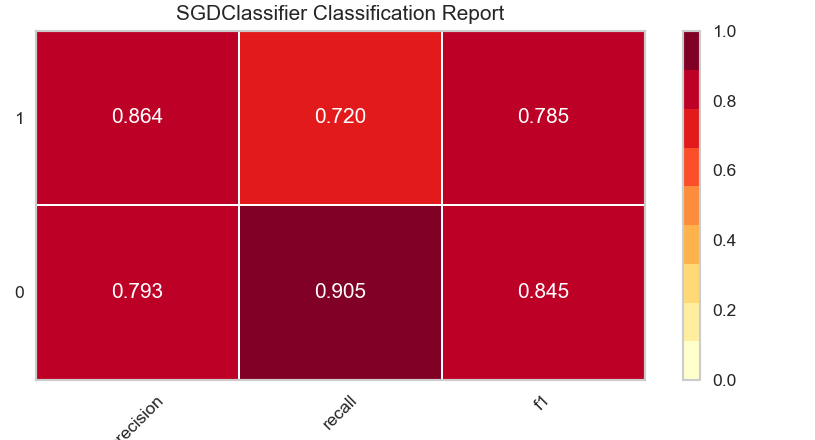

In [103]:
visual_model_selection(X, y, SGDClassifier())